In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
import statsmodels.graphics.tsaplots as sgt

import warnings

# 모든 경고 메시지 끄기
warnings.filterwarnings('ignore')

# 폰트 깨짐 방지
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False


plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

# 1.데이터 불러오기

In [3]:
data = pd.read_csv("/content/drive/MyDrive/삼성화재&Postech 데이터 리스크 /데이터/개화/복숭아 개화 데이터.csv", encoding = "cp949")

# 불필요한 열 제거
data.drop(columns = ['index'], inplace=True)

# 범주화
data = pd.get_dummies(data, columns=['해양'])

# 여러 열을 동시에 datetime으로 변환
date_columns = ['복숭아 개화', '서리끝']
data[date_columns] = data[date_columns].apply(pd.to_datetime)

# 분석에 불필요한 열 제거 2차
data = data.drop(columns=['복숭아 개화(평비)', '서리끝'])


data

,지점,연,복숭아 개화,365,서리끝(평비),서리365,위도,경도,고도,2_일강수량(mm)_sum,...,2_평균기온(°C)_max,3_평균기온(°C)_max,2_평균기온(°C)_mean,3_평균기온(°C)_mean,2_평균기온(°C)_min,3_평균기온(°C)_min,2_합계 일조시간(hr)_sum,3_합계 일조시간(hr)_sum,해양_0.0,해양_1.0
0,강릉,1989.0,1989-04-05,95,3.45,85.0,37.762825,128.9357,26.29,81.5,...,9.6,14.6,3.696429,6.677419,-2.1,-0.2,157.4,154.0,False,True
1,강릉,1990.0,1990-04-02,92,3.45,85.0,37.762825,128.9357,26.29,149.4,...,6.6,13.3,3.200000,7.958065,-0.2,2.0,93.0,171.9,False,True
2,강릉,1991.0,1991-04-15,105,10.45,92.0,37.762825,128.9357,26.29,50.2,...,5.9,15.5,0.814286,5.454839,-9.1,0.5,166.0,141.3,False,True
3,강릉,1992.0,1992-04-04,95,-2.55,79.0,37.762825,128.9357,26.29,11.7,...,15.5,14.2,2.865517,6.374194,-2.0,1.2,191.7,137.0,False,True
4,강릉,1993.0,1993-04-13,103,20.45,102.0,37.762825,128.9357,26.29,65.3,...,14.3,11.9,3.103571,6.090323,-3.4,-1.7,185.2,188.7,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,충주,2010.0,2010-04-25,115,4.00,107.0,36.970500,127.9525,114.85,70.8,...,13.7,9.3,0.496429,4.303226,-7.3,-1.5,137.5,128.5,True,False
1881,충주,2011.0,2011-04-17,107,0.00,103.0,36.970500,127.9525,114.85,45.9,...,5.4,9.9,-0.010714,3.222581,-5.7,-2.3,153.8,242.9,True,False
1882,충주,2012.0,2012-04-16,107,-5.00,99.0,36.970500,127.9525,114.85,1.7,...,4.6,12.0,-2.496552,5.141935,-15.0,-1.6,217.8,187.2,True,False
1883,충주,2013.0,2013-04-23,113,0.00,103.0,36.970500,127.9525,114.85,36.9,...,9.1,13.2,-1.292857,5.206452,-11.6,-1.0,179.2,255.5,True,False


# 2.EDA

In [4]:
# !pip install statsmodels

from pprint import pprint
from collections import defaultdict
from datetime import datetime
from sklearn.metrics import r2_score, mean_squared_error

import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
selected_columns = ['연', '365', '서리끝(평비)', '서리365', '위도', '경도', '고도',
       '2_일강수량(mm)_sum', '3_일강수량(mm)_sum', '2_최고기온(°C)_max', '3_최고기온(°C)_max',
       '2_최고기온(°C)_mean', '3_최고기온(°C)_mean', '2_최고기온(°C)_min',
       '3_최고기온(°C)_min', '2_최저기온(°C)_max', '3_최저기온(°C)_max', '2_최저기온(°C)_mean',
       '3_최저기온(°C)_mean', '2_최저기온(°C)_min', '3_최저기온(°C)_min', '2_평균기온(°C)_max',
       '3_평균기온(°C)_max', '2_평균기온(°C)_mean', '3_평균기온(°C)_mean',
       '2_평균기온(°C)_min', '3_평균기온(°C)_min', '2_합계 일조시간(hr)_sum',
       '3_합계 일조시간(hr)_sum']

In [6]:
preprocessed_data = data.reindex(columns=selected_columns)

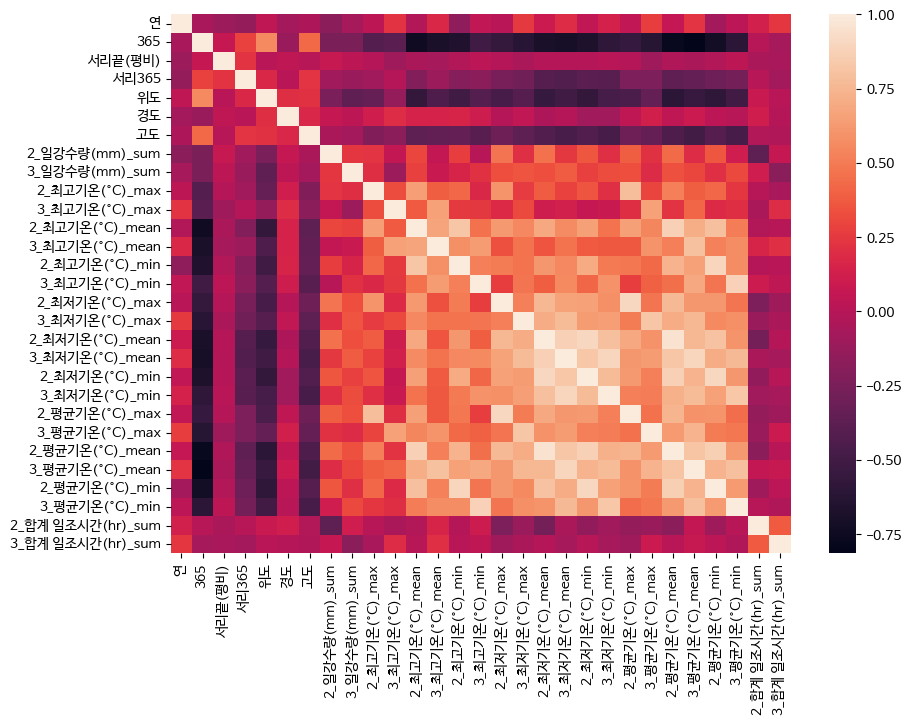

In [7]:
def plot_correlation(corr):
    plt.figure(figsize=(10,7))
    sns.heatmap(corr)
    plt.show()

plot_correlation(preprocessed_data.corr())

In [8]:
# VIF를 계산하는 함수
def calculate_vif(data_frame, excluded_variable = None):
    if excluded_variable:
      data_frame = data_frame.drop(excluded_variable, axis=1)
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data.sort_values(by='VIF', ascending = False)

In [ ]:
from statsmodels.datasets.longley import load_pandas
plt.figure(figsize=(20,20))
sns.pairplot(preprocessed_data)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [9]:
vif_selected_data = calculate_vif(preprocessed_data, excluded_variable = ["365","경도","위도",'연'])
vif_selected_data

,Variable,VIF
20,3_평균기온(°C)_mean,1596.777445
8,3_최고기온(°C)_mean,1358.944884
7,2_최고기온(°C)_mean,587.946340
19,2_평균기온(°C)_mean,430.422018
13,2_최저기온(°C)_mean,275.373912
6,3_최고기온(°C)_max,268.864152
18,3_평균기온(°C)_max,216.188985
5,2_최고기온(°C)_max,115.812199
15,2_최저기온(°C)_min,106.447336
14,3_최저기온(°C)_mean,87.338667


In [10]:
print(vif_selected_data.Variable.values)

['3_평균기온(°C)_mean' '3_최고기온(°C)_mean' '2_최고기온(°C)_mean' '2_평균기온(°C)_mean'
 '2_최저기온(°C)_mean' '3_최고기온(°C)_max' '3_평균기온(°C)_max' '2_최고기온(°C)_max'
 '2_최저기온(°C)_min' '3_최저기온(°C)_mean' '2_평균기온(°C)_max' '2_평균기온(°C)_min'
 '2_합계 일조시간(hr)_sum' '3_합계 일조시간(hr)_sum' '3_최저기온(°C)_max' '3_최저기온(°C)_min'
 '3_최고기온(°C)_min' '2_최저기온(°C)_max' '3_평균기온(°C)_min' '서리365'
 '2_최고기온(°C)_min' '3_일강수량(mm)_sum' '2_일강수량(mm)_sum' '고도' '서리끝(평비)']


In [11]:
vif_selected_data_3 = calculate_vif(preprocessed_data, excluded_variable = ["365","경도","위도", '2_최고기온(°C)_mean', '2_평균기온(°C)_mean', '2_최저기온(°C)_mean', '2_최고기온(°C)_max',  ])

In [12]:
print(vif_selected_data.Variable.values)
print(vif_selected_data.VIF.values)


['3_평균기온(°C)_mean' '3_최고기온(°C)_mean' '2_최고기온(°C)_mean' '2_평균기온(°C)_mean'
 '2_최저기온(°C)_mean' '3_최고기온(°C)_max' '3_평균기온(°C)_max' '2_최고기온(°C)_max'
 '2_최저기온(°C)_min' '3_최저기온(°C)_mean' '2_평균기온(°C)_max' '2_평균기온(°C)_min'
 '2_합계 일조시간(hr)_sum' '3_합계 일조시간(hr)_sum' '3_최저기온(°C)_max' '3_최저기온(°C)_min'
 '3_최고기온(°C)_min' '2_최저기온(°C)_max' '3_평균기온(°C)_min' '서리365'
 '2_최고기온(°C)_min' '3_일강수량(mm)_sum' '2_일강수량(mm)_sum' '고도' '서리끝(평비)']
[1.59677745e+03 1.35894488e+03 5.87946340e+02 4.30422018e+02
 2.75373912e+02 2.68864152e+02 2.16188985e+02 1.15812199e+02
 1.06447336e+02 8.73386672e+01 8.65184545e+01 7.58292444e+01
 6.98756427e+01 6.06390447e+01 5.14136972e+01 3.35016940e+01
 2.24608127e+01 2.03616707e+01 1.33875273e+01 1.20844089e+01
 1.10003249e+01 4.47313797e+00 4.22527439e+00 2.95880025e+00
 1.11297627e+00]


In [13]:
data[vif_seleced_columns].corr()

NameError: ignored

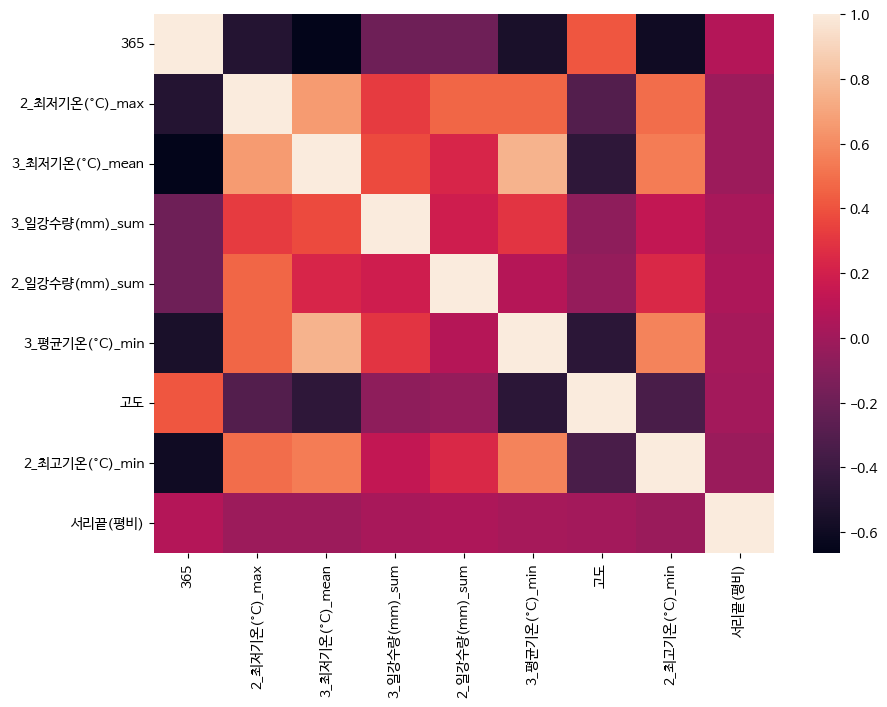

In [ ]:
vif_seleced_columns = ['365', '2_최저기온(°C)_max', '3_최저기온(°C)_mean', '3_일강수량(mm)_sum',
       '2_일강수량(mm)_sum', '3_평균기온(°C)_min', '고도', '2_최고기온(°C)_min','서리끝(평비)']

plot_correlation(data[vif_seleced_columns].corr())

In [ ]:
#  최종 변수 = [ '3_최저기온(°C)_mean', '3_일강수량(mm)_sum' '2_일강수량(mm)_sum', '고도', '2_최고기온(°C)_min' '서리끝(평비)']

In [ ]:
data

,지점,연,배나무 개화,365,서리끝(평비),서리365,위도,경도,고도,2_일강수량(mm)_sum,...,2_평균기온(°C)_max,3_평균기온(°C)_max,2_평균기온(°C)_mean,3_평균기온(°C)_mean,2_평균기온(°C)_min,3_평균기온(°C)_min,2_합계 일조시간(hr)_sum,3_합계 일조시간(hr)_sum,해양_0.0,해양_1.0
0,강릉,1989.0,1989-04-17,107,3.45,85.0,37.762825,128.9357,26.29,81.5,...,9.6,14.6,3.696429,6.677419,-2.1,-0.2,157.4,154.0,0,1
1,강릉,1990.0,1990-04-14,104,3.45,85.0,37.762825,128.9357,26.29,149.4,...,6.6,13.3,3.200000,7.958065,-0.2,2.0,93.0,171.9,0,1
2,강릉,1991.0,1991-04-21,111,10.45,92.0,37.762825,128.9357,26.29,50.2,...,5.9,15.5,0.814286,5.454839,-9.1,0.5,166.0,141.3,0,1
3,강릉,1992.0,1992-04-04,95,-2.55,79.0,37.762825,128.9357,26.29,11.7,...,15.5,14.2,2.865517,6.374194,-2.0,1.2,191.7,137.0,0,1
4,강릉,1993.0,1993-04-20,110,20.45,102.0,37.762825,128.9357,26.29,65.3,...,14.3,11.9,3.103571,6.090323,-3.4,-1.7,185.2,188.7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,충주,2010.0,2010-04-20,110,4.00,107.0,36.970500,127.9525,114.85,70.8,...,13.7,9.3,0.496429,4.303226,-7.3,-1.5,137.5,128.5,1,0
1850,충주,2011.0,2011-04-13,103,0.00,103.0,36.970500,127.9525,114.85,45.9,...,5.4,9.9,-0.010714,3.222581,-5.7,-2.3,153.8,242.9,1,0
1851,충주,2012.0,2012-04-19,110,-5.00,99.0,36.970500,127.9525,114.85,1.7,...,4.6,12.0,-2.496552,5.141935,-15.0,-1.6,217.8,187.2,1,0
1852,충주,2013.0,2013-04-17,107,0.00,103.0,36.970500,127.9525,114.85,36.9,...,9.1,13.2,-1.292857,5.206452,-11.6,-1.0,179.2,255.5,1,0


# 3.모델링

In [ ]:
# 모델링용 데이터셋 구성

data

In [ ]:
!pip install optuna
!pip install catboost
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

import re
import optuna
from optuna.integration import XGBoostPruningCallback

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler


from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor , GradientBoostingRegressor

In [ ]:
# 최종 변수 = [ '3_최저기온(°C)_mean', '3_일강수량(mm)_sum' '2_일강수량(mm)_sum', '고도', '2_최고기온(°C)_min' '서리끝(평비)']

In [ ]:
final_selected_var= [ '3_최저기온(°C)_mean', '3_일강수량(mm)_sum', '2_일강수량(mm)_sum', '고도', '2_최고기온(°C)_min' ,'서리끝(평비)']

In [ ]:
x_train = data[final_selected_var].iloc[:1443, :]
y_train = data['365'][:1443]

x_test = data[final_selected_var].iloc[1443: ,:]                      # 임실 이후부터 test set
y_test = data['365'][1443:]


# X = data[final_selected_var]
# y = data['365']
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [ ]:
# scaler = RobustScaler()
# scaler.fit(x_train)
# x_train_scaled = scaler.transform(x_train)
# x_test_scaled = scaler.transform(x_test)

In [ ]:
# x_train_scaled

In [ ]:
def MAE_cv(model, X_train, X_test, y_train, y_test, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    mae_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(kf.split(x_train), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Robust scaling
        scaler = RobustScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_test_fold_scaled = scaler.transform(X_test_fold)

        clf = model.fit(X_train_fold_scaled, y_train_fold)
        pred = clf.predict(X_test_fold_scaled)
        mae = mean_absolute_error(y_test_fold, pred)
        mae_list.append(mae)
    return model_name, mae_list

def print_mae_score(model, X_train, X_test, y_train, y_test):
    model_name, score = MAE_cv(model, X_train, X_test, y_train, y_test)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} mae: {r:.4f}')
    print(f'\n{model_name} mean mae: {np.mean(score):.4f}')
    print('=' * 40)
    return model_name, np.mean(score)

reg = LinearRegression()
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha=0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
catboost = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, loss_function='MAE', verbose=False)
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5)
histboost = HistGradientBoostingRegressor()
GBR = GradientBoostingRegressor()
rf = RandomForestRegressor(random_state=1, max_depth=5, min_samples_leaf=8, min_samples_split=8,n_estimators=200)

In [ ]:
# Predict
models = []
scores = []
for model in [reg,ridge,lasso,Enet,catboost,model_xgb,model_lgb,histboost,GBR, rf]:
    model_name, mean_score = print_mae_score(model, x_train, x_test, y_train, y_test)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 154.49it/s]


1 FOLDS: LinearRegression mae: 4.5530
2 FOLDS: LinearRegression mae: 4.9184
3 FOLDS: LinearRegression mae: 4.6345
4 FOLDS: LinearRegression mae: 4.9064
5 FOLDS: LinearRegression mae: 4.5626
6 FOLDS: LinearRegression mae: 5.1783
7 FOLDS: LinearRegression mae: 5.4068
8 FOLDS: LinearRegression mae: 4.8710
9 FOLDS: LinearRegression mae: 4.5120
10 FOLDS: LinearRegression mae: 4.8934

LinearRegression mean mae: 4.8436


Ridge Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 203.32it/s]


1 FOLDS: Ridge mae: 4.5521
2 FOLDS: Ridge mae: 4.9183
3 FOLDS: Ridge mae: 4.6349
4 FOLDS: Ridge mae: 4.9061
5 FOLDS: Ridge mae: 4.5634
6 FOLDS: Ridge mae: 5.1773
7 FOLDS: Ridge mae: 5.4072
8 FOLDS: Ridge mae: 4.8718
9 FOLDS: Ridge mae: 4.5115
10 FOLDS: Ridge mae: 4.8926

Ridge mean mae: 4.8435


Lasso Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 210.21it/s]


1 FOLDS: Lasso mae: 4.5515
2 FOLDS: Lasso mae: 4.9181
3 FOLDS: Lasso mae: 4.6362
4 FOLDS: Lasso mae: 4.9065
5 FOLDS: Lasso mae: 4.5661
6 FOLDS: Lasso mae: 5.1730
7 FOLDS: Lasso mae: 5.4058
8 FOLDS: Lasso mae: 4.8744
9 FOLDS: Lasso mae: 4.5124
10 FOLDS: Lasso mae: 4.8935

Lasso mean mae: 4.8437


ElasticNet Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 174.83it/s]


1 FOLDS: ElasticNet mae: 4.5201
2 FOLDS: ElasticNet mae: 4.9161
3 FOLDS: ElasticNet mae: 4.6598
4 FOLDS: ElasticNet mae: 4.8915
5 FOLDS: ElasticNet mae: 4.6001
6 FOLDS: ElasticNet mae: 5.1414
7 FOLDS: ElasticNet mae: 5.4393
8 FOLDS: ElasticNet mae: 4.9219
9 FOLDS: ElasticNet mae: 4.4941
10 FOLDS: ElasticNet mae: 4.8619

ElasticNet mean mae: 4.8446


CatBoostRegressor Cross Validations...: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


1 FOLDS: CatBoostRegressor mae: 4.1300
2 FOLDS: CatBoostRegressor mae: 4.5457
3 FOLDS: CatBoostRegressor mae: 4.7256
4 FOLDS: CatBoostRegressor mae: 4.5888
5 FOLDS: CatBoostRegressor mae: 4.3800
6 FOLDS: CatBoostRegressor mae: 4.8624
7 FOLDS: CatBoostRegressor mae: 4.7434
8 FOLDS: CatBoostRegressor mae: 5.0240
9 FOLDS: CatBoostRegressor mae: 4.2174
10 FOLDS: CatBoostRegressor mae: 4.5277

CatBoostRegressor mean mae: 4.5745


XGBRegressor Cross Validations...: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


1 FOLDS: XGBRegressor mae: 4.1257
2 FOLDS: XGBRegressor mae: 4.8944
3 FOLDS: XGBRegressor mae: 4.7360
4 FOLDS: XGBRegressor mae: 4.3801
5 FOLDS: XGBRegressor mae: 4.5627
6 FOLDS: XGBRegressor mae: 4.8418
7 FOLDS: XGBRegressor mae: 4.7342
8 FOLDS: XGBRegressor mae: 4.7803
9 FOLDS: XGBRegressor mae: 4.4265
10 FOLDS: XGBRegressor mae: 5.0812

XGBRegressor mean mae: 4.6563


LGBMRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 1298, number of used features: 6
[LightGBM] [Info] Start training from score 102.147149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

LGBMRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:02,  3.14it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:02,  3.20it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 1298, number of used features: 6
[LightGBM] [Info] Start training from score 102.346687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

LGBMRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:02,  3.24it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  40%|████      | 4/10 [00:01<00:01,  3.21it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 1299, number of used features: 6
[LightGBM] [Info] Start training from score 102.281755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  3.27it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  60%|██████    | 6/10 [00:01<00:01,  3.23it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 1299, number of used features: 6
[LightGBM] [Info] Start training from score 102.192456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

LGBMRegressor Cross Validations...:  70%|███████   | 7/10 [00:02<00:00,  3.24it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  80%|████████  | 8/10 [00:02<00:00,  3.13it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 1299, number of used features: 6
[LightGBM] [Info] Start training from score 102.120862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

LGBMRegressor Cross Validations...:  90%|█████████ | 9/10 [00:02<00:00,  3.14it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


1 FOLDS: LGBMRegressor mae: 4.0755
2 FOLDS: LGBMRegressor mae: 4.7960
3 FOLDS: LGBMRegressor mae: 4.9785
4 FOLDS: LGBMRegressor mae: 4.7204
5 FOLDS: LGBMRegressor mae: 4.6099
6 FOLDS: LGBMRegressor mae: 4.7569
7 FOLDS: LGBMRegressor mae: 5.1620
8 FOLDS: LGBMRegressor mae: 4.6320
9 FOLDS: LGBMRegressor mae: 4.5127
10 FOLDS: LGBMRegressor mae: 4.8515

LGBMRegressor mean mae: 4.7096


HistGradientBoostingRegressor Cross Validations...: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


1 FOLDS: HistGradientBoostingRegressor mae: 4.0661
2 FOLDS: HistGradientBoostingRegressor mae: 4.4709
3 FOLDS: HistGradientBoostingRegressor mae: 4.7728
4 FOLDS: HistGradientBoostingRegressor mae: 4.4985
5 FOLDS: HistGradientBoostingRegressor mae: 4.5054
6 FOLDS: HistGradientBoostingRegressor mae: 4.6321
7 FOLDS: HistGradientBoostingRegressor mae: 4.9310
8 FOLDS: HistGradientBoostingRegressor mae: 4.6425
9 FOLDS: HistGradientBoostingRegressor mae: 4.0991
10 FOLDS: HistGradientBoostingRegressor mae: 4.5918

HistGradientBoostingRegressor mean mae: 4.5210


GradientBoostingRegressor Cross Validations...: 100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


1 FOLDS: GradientBoostingRegressor mae: 4.0510
2 FOLDS: GradientBoostingRegressor mae: 4.6301
3 FOLDS: GradientBoostingRegressor mae: 4.5156
4 FOLDS: GradientBoostingRegressor mae: 4.6256
5 FOLDS: GradientBoostingRegressor mae: 4.4631
6 FOLDS: GradientBoostingRegressor mae: 4.6635
7 FOLDS: GradientBoostingRegressor mae: 4.7554
8 FOLDS: GradientBoostingRegressor mae: 4.3462
9 FOLDS: GradientBoostingRegressor mae: 4.0214
10 FOLDS: GradientBoostingRegressor mae: 4.6732

GradientBoostingRegressor mean mae: 4.4745


RandomForestRegressor Cross Validations...: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

1 FOLDS: RandomForestRegressor mae: 4.3097
2 FOLDS: RandomForestRegressor mae: 4.8165
3 FOLDS: RandomForestRegressor mae: 4.7344
4 FOLDS: RandomForestRegressor mae: 4.6521
5 FOLDS: RandomForestRegressor mae: 4.7265
6 FOLDS: RandomForestRegressor mae: 5.0892
7 FOLDS: RandomForestRegressor mae: 5.1597
8 FOLDS: RandomForestRegressor mae: 4.6278
9 FOLDS: RandomForestRegressor mae: 4.4008
10 FOLDS: RandomForestRegressor mae: 4.7570

RandomForestRegressor mean mae: 4.7274


In [ ]:
# Predict
models = []
scores = []
for model in [reg,ridge,lasso,Enet,catboost,model_xgb,model_lgb,histboost,GBR, rf]:
    model_name, mean_score = print_rmae_score(model, x_train, x_test, y_train, y_test)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 179.87it/s]


1 FOLDS: LinearRegression rmae: 2.1338
2 FOLDS: LinearRegression rmae: 2.2178
3 FOLDS: LinearRegression rmae: 2.1528
4 FOLDS: LinearRegression rmae: 2.2150
5 FOLDS: LinearRegression rmae: 2.1360
6 FOLDS: LinearRegression rmae: 2.2756
7 FOLDS: LinearRegression rmae: 2.3252
8 FOLDS: LinearRegression rmae: 2.2070
9 FOLDS: LinearRegression rmae: 2.1241
10 FOLDS: LinearRegression rmae: 2.2121

LinearRegression mean rmae: 2.1999


Ridge Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 215.34it/s]


1 FOLDS: Ridge rmae: 2.1338
2 FOLDS: Ridge rmae: 2.2178
3 FOLDS: Ridge rmae: 2.1528
4 FOLDS: Ridge rmae: 2.2150
5 FOLDS: Ridge rmae: 2.1360
6 FOLDS: Ridge rmae: 2.2756
7 FOLDS: Ridge rmae: 2.3253
8 FOLDS: Ridge rmae: 2.2070
9 FOLDS: Ridge rmae: 2.1241
10 FOLDS: Ridge rmae: 2.2121

Ridge mean rmae: 2.1999


Lasso Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 206.97it/s]


1 FOLDS: Lasso rmae: 2.1336
2 FOLDS: Lasso rmae: 2.2177
3 FOLDS: Lasso rmae: 2.1529
4 FOLDS: Lasso rmae: 2.2150
5 FOLDS: Lasso rmae: 2.1362
6 FOLDS: Lasso rmae: 2.2754
7 FOLDS: Lasso rmae: 2.3253
8 FOLDS: Lasso rmae: 2.2072
9 FOLDS: Lasso rmae: 2.1241
10 FOLDS: Lasso rmae: 2.2120

Lasso mean rmae: 2.1999


ElasticNet Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 167.54it/s]


1 FOLDS: ElasticNet rmae: 2.1330
2 FOLDS: ElasticNet rmae: 2.2178
3 FOLDS: ElasticNet rmae: 2.1531
4 FOLDS: ElasticNet rmae: 2.2149
5 FOLDS: ElasticNet rmae: 2.1367
6 FOLDS: ElasticNet rmae: 2.2748
7 FOLDS: ElasticNet rmae: 2.3257
8 FOLDS: ElasticNet rmae: 2.2078
9 FOLDS: ElasticNet rmae: 2.1237
10 FOLDS: ElasticNet rmae: 2.2115

ElasticNet mean rmae: 2.1999


CatBoostRegressor Cross Validations...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


1 FOLDS: CatBoostRegressor rmae: 2.0320
2 FOLDS: CatBoostRegressor rmae: 2.1321
3 FOLDS: CatBoostRegressor rmae: 2.1742
4 FOLDS: CatBoostRegressor rmae: 2.1201
5 FOLDS: CatBoostRegressor rmae: 2.0927
6 FOLDS: CatBoostRegressor rmae: 2.2049
7 FOLDS: CatBoostRegressor rmae: 2.1780
8 FOLDS: CatBoostRegressor rmae: 2.2416
9 FOLDS: CatBoostRegressor rmae: 2.0541
10 FOLDS: CatBoostRegressor rmae: 2.1106

CatBoostRegressor mean rmae: 2.1340


XGBRegressor Cross Validations...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


1 FOLDS: XGBRegressor rmae: 2.0301
2 FOLDS: XGBRegressor rmae: 2.2138
3 FOLDS: XGBRegressor rmae: 2.1686
4 FOLDS: XGBRegressor rmae: 2.0973
5 FOLDS: XGBRegressor rmae: 2.1301
6 FOLDS: XGBRegressor rmae: 2.1975
7 FOLDS: XGBRegressor rmae: 2.1760
8 FOLDS: XGBRegressor rmae: 2.1873
9 FOLDS: XGBRegressor rmae: 2.1023
10 FOLDS: XGBRegressor rmae: 2.2554

XGBRegressor mean rmae: 2.1558


LGBMRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1051
[LightGBM] [Info] Number of data points in the train set: 1298, number of used features: 6
[LightGBM] [Info] Start training from score 102.147149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

LGBMRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:02,  3.50it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:02,  3.47it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:02,  3.35it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  40%|████      | 4/10 [00:01<00:01,  3.33it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  3.35it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  60%|██████    | 6/10 [00:01<00:01,  3.35it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  70%|███████   | 7/10 [00:02<00:01,  2.91it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

LGBMRegressor Cross Validations...:  80%|████████  | 8/10 [00:02<00:00,  2.78it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  90%|█████████ | 9/10 [00:03<00:00,  2.71it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

HistGradientBoostingRegressor Cross Validations...: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


1 FOLDS: HistGradientBoostingRegressor rmae: 1.9826
2 FOLDS: HistGradientBoostingRegressor rmae: 2.1185
3 FOLDS: HistGradientBoostingRegressor rmae: 2.1797
4 FOLDS: HistGradientBoostingRegressor rmae: 2.1284
5 FOLDS: HistGradientBoostingRegressor rmae: 2.1452
6 FOLDS: HistGradientBoostingRegressor rmae: 2.1388
7 FOLDS: HistGradientBoostingRegressor rmae: 2.2108
8 FOLDS: HistGradientBoostingRegressor rmae: 2.1378
9 FOLDS: HistGradientBoostingRegressor rmae: 2.0409
10 FOLDS: HistGradientBoostingRegressor rmae: 2.1723

HistGradientBoostingRegressor mean rmae: 2.1255


GradientBoostingRegressor Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


1 FOLDS: GradientBoostingRegressor rmae: 2.0128
2 FOLDS: GradientBoostingRegressor rmae: 2.1511
3 FOLDS: GradientBoostingRegressor rmae: 2.1250
4 FOLDS: GradientBoostingRegressor rmae: 2.1501
5 FOLDS: GradientBoostingRegressor rmae: 2.1138
6 FOLDS: GradientBoostingRegressor rmae: 2.1583
7 FOLDS: GradientBoostingRegressor rmae: 2.1800
8 FOLDS: GradientBoostingRegressor rmae: 2.0825
9 FOLDS: GradientBoostingRegressor rmae: 2.0074
10 FOLDS: GradientBoostingRegressor rmae: 2.1604

GradientBoostingRegressor mean rmae: 2.1141


RandomForestRegressor Cross Validations...: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

1 FOLDS: RandomForestRegressor rmae: 2.0761
2 FOLDS: RandomForestRegressor rmae: 2.1949
3 FOLDS: RandomForestRegressor rmae: 2.1759
4 FOLDS: RandomForestRegressor rmae: 2.1567
5 FOLDS: RandomForestRegressor rmae: 2.1741
6 FOLDS: RandomForestRegressor rmae: 2.2559
7 FOLDS: RandomForestRegressor rmae: 2.2713
8 FOLDS: RandomForestRegressor rmae: 2.1512
9 FOLDS: RandomForestRegressor rmae: 2.0976
10 FOLDS: RandomForestRegressor rmae: 2.1810

RandomForestRegressor mean rmae: 2.1735
